<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.pipeline import Pipeline

## Подготовка

Загрузим и рассмотрим данные:

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv("C:/Users/chern/taxi.csv",  index_col=[0], parse_dates=[0])
    
display(df.head(10))
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Выполним ресемплирование по одному часу и отсортируем данные:

In [3]:
df = df.resample('1H').sum()

In [4]:
df = df.sort_index(ascending=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**
- Данные состоят из 2 столбцов и 26496 строк. 
- Перевели столбец datetime в формат datetime64.
- Ресемплировали данные по одному часу.
- Установили столбец datetime в качестве индекса.

## Анализ

Посмотрим данные на графике временных рядов:

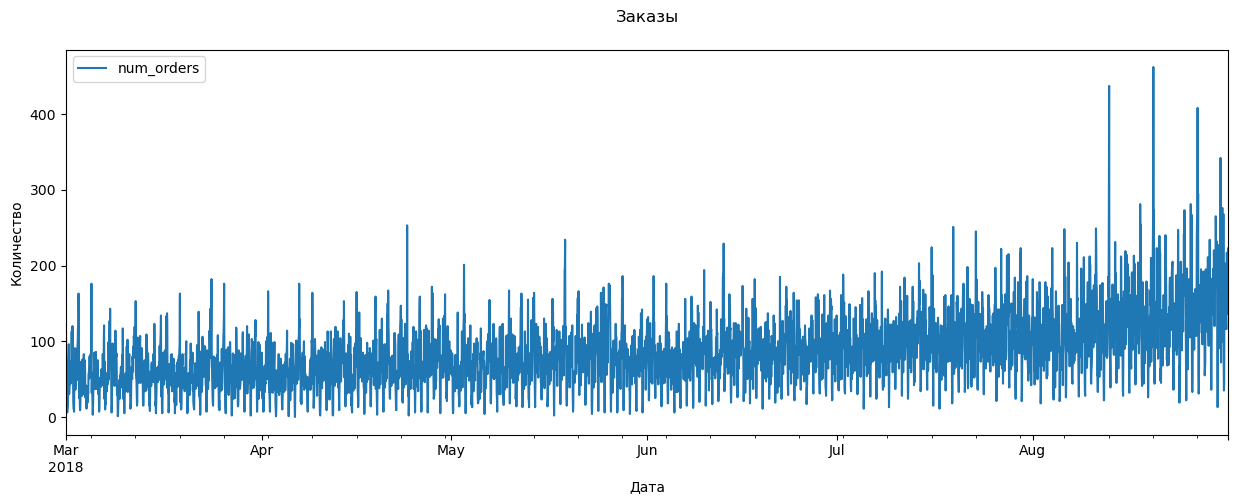

In [5]:
df.plot(figsize=(15,5))
plt.title('Заказы', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

На графике видим, что представленно измение данных в периоде с марта по сентябрь 2018 года.

Рассмотрим тренд и скользящее среднее:

In [6]:
decomposed_df = seasonal_decompose(df)

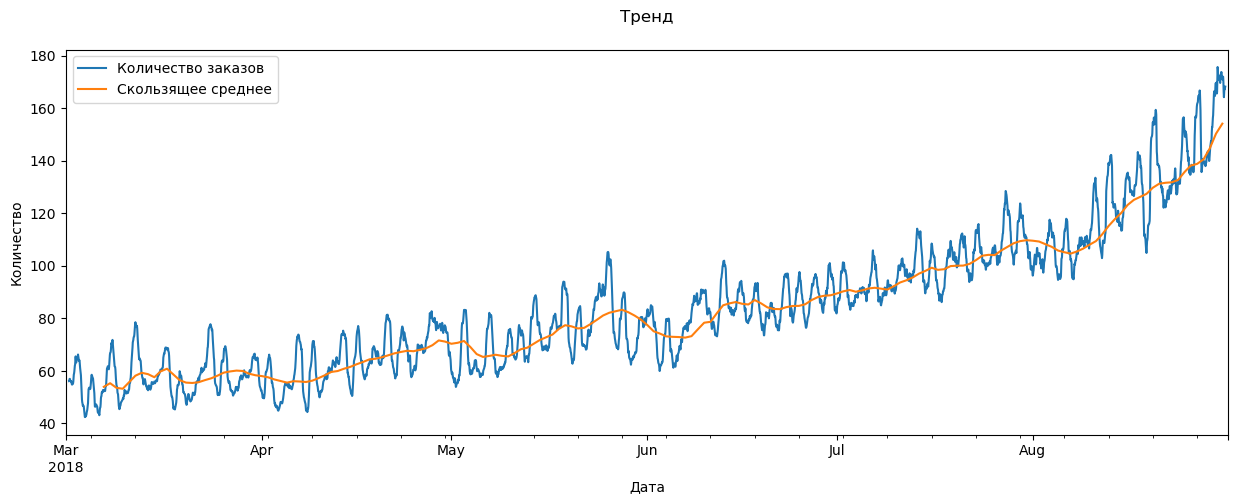

In [7]:
decomposed_df.trend.plot(ax=plt.gca(),figsize=(15,5))
decomposed_df.trend.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(15,5))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('Тренд', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

Наблюдается явный тренд к постепенному увеличению количества заказов такси.

Рассмотрим сеезонность в данных:

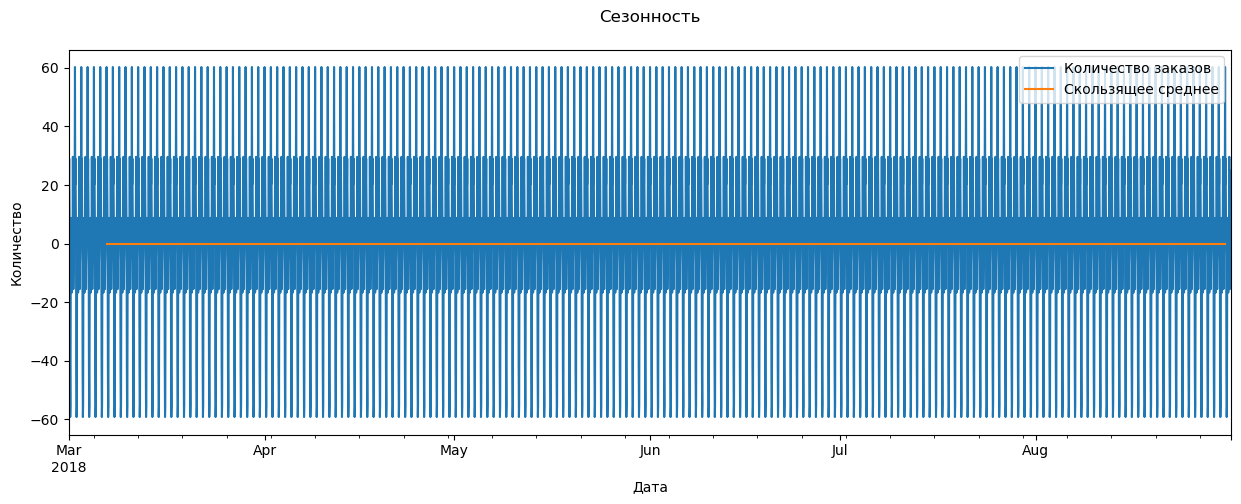

In [8]:
decomposed_df.seasonal.plot(ax=plt.gca(),figsize=(15,5))
decomposed_df.seasonal.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(15,5))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('Сезонность', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

Данные стационарны (среднее значение и отклонение не изменяются), сезонных изменений не наблюдается.

Рассмотрим сезонность заказа такси по дням недели, для этого возьмем последние 2 недели августа:

In [9]:
decomposed_seasonal_days = decomposed_df.seasonal['2018-08-18':'2018-08-31']
print('Стандартное отклонение:', decomposed_seasonal_days.std())
print('Среднее значение:', decomposed_seasonal_days.mean())

Стандартное отклонение: 26.192630524844052
Среднее значение: 3.383536836952858e-16


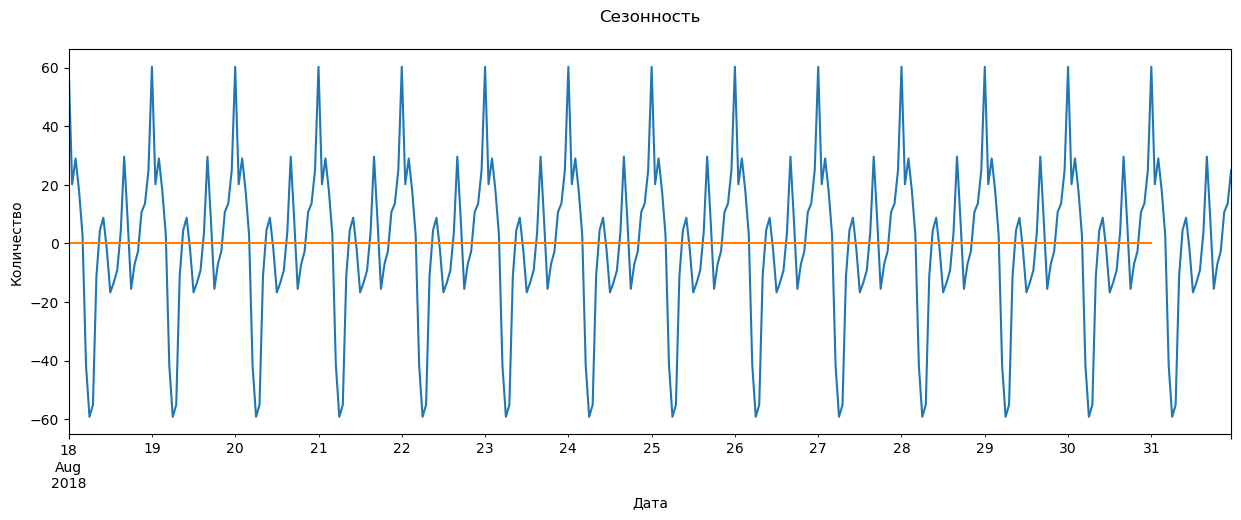

In [10]:
decomposed_seasonal_days.plot(ax=plt.gca(),figsize=(15,5))
decomposed_seasonal_days.resample('1D').mean().plot(ax=plt.gca(),figsize=(15,5))
plt.title('Сезонность', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

По дням недели также не наблюдается сезонности.

Рассмотрим сезонность по времени суток, возьмем последние 3 дня августа:

In [11]:
decomposed_seasonal_hours = decomposed_df.seasonal['2018-08-29':'2018-08-31']
print('Стандартное отклонение:', decomposed_seasonal_hours.std())
print('Среднее значение:', decomposed_seasonal_hours.mean())

Стандартное отклонение: 26.33716080972188
Среднее значение: 0.0


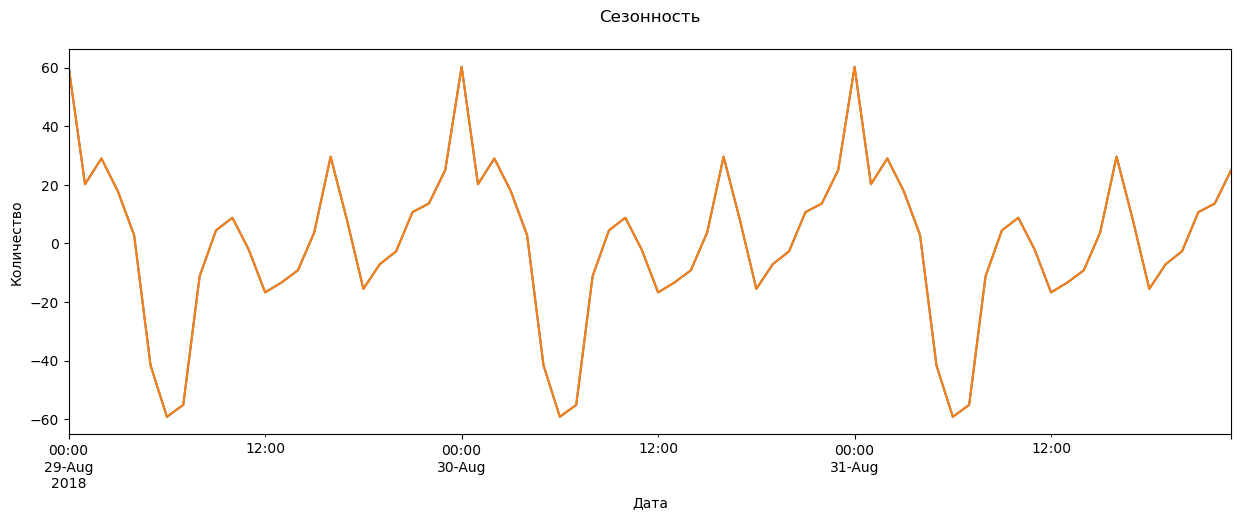

In [12]:
decomposed_seasonal_hours.plot(ax=plt.gca(),figsize=(15,5))
decomposed_seasonal_hours.resample('1H').mean().plot(ax=plt.gca(),figsize=(15,5))
plt.title('Сезонность', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

В рамках суток видим сезонность по часам. Спрос на такси растет в вечернее время и начинает резко падать после часа ночи. Наименее популярны услуги такси ранним утром около 6 утра.

Рассмотрим остатки декомпозиции:

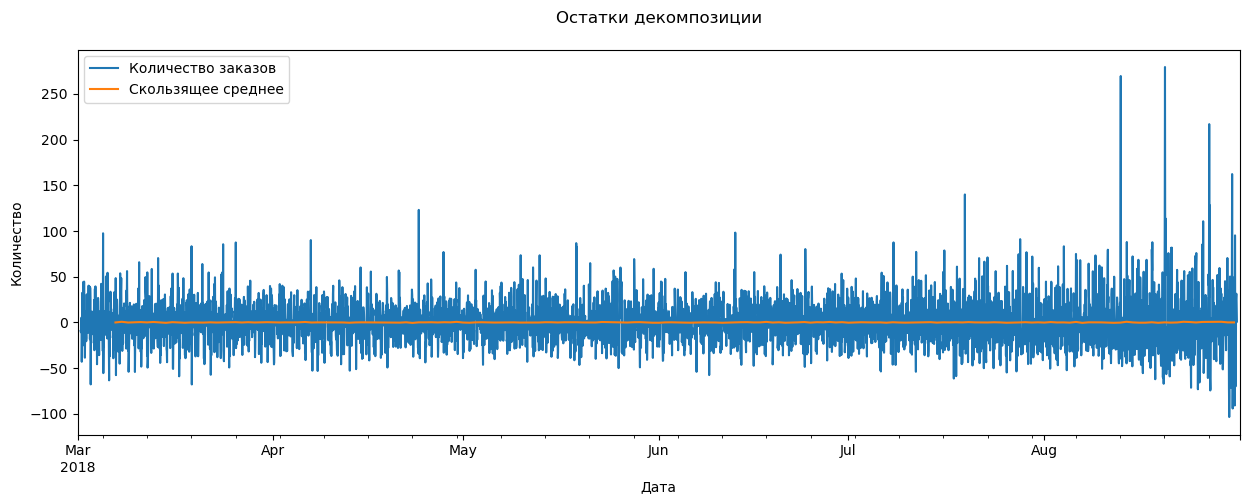

In [13]:
decomposed_df.resid.plot(ax=plt.gca(),figsize=(15,5))
decomposed_df.resid.resample('1D').mean().rolling(7).mean().plot(ax=plt.gca(),figsize=(15,5))
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.title('Остатки декомпозиции', y=1.05)
plt.xlabel('Дата')
plt.ylabel('Количество');

На графике видим большое количество шумов.

**Вывод:**
- Представленно измение данных в периоде с марта по сентябрь 2018 года.
- Наблюдается явный тренд к постепенному увеличению количества заказов такси.
- Данные сезонности стационарны (среднее значение и отклонение не изменяются), сезонных изменений по всему периоду и по дням недели не наблюдается.
- В рамках суток видим сезонность по часам. Спрос на такси растет в вечернее время и начинает резко падать после часа ночи. Наименее популярны услуги такси ранним утром около 6 утра.

## Обучение

Добавим в датафрейм столбцы с признаками:

In [14]:
df['rolling_mean'] = df.shift().rolling(7).mean()

In [15]:
df['dayofweek'] = df.index.dayofweek
df['time'] = df.index.hour

df.head()

,num_orders,rolling_mean,dayofweek,time
datetime,,,,
2018-03-01 00:00:00,124,NaN,3,0
2018-03-01 01:00:00,85,NaN,3,1
2018-03-01 02:00:00,71,NaN,3,2
2018-03-01 03:00:00,66,NaN,3,3
2018-03-01 04:00:00,43,NaN,3,4


Проверим обновленный дафрейм на пропуски и дубликаты:

In [16]:
df.isna().sum()

num_orders      0
rolling_mean    7
dayofweek       0
time            0
dtype: int64

In [17]:
df['rolling_mean'].isna().sum() / len(df['num_orders'])*100

0.1585144927536232

Пропусков очень мало, поэтому можем их удалить:

In [18]:
df = df.dropna()

In [19]:
df.duplicated().sum()

0

Разделим данные на обучающую и тестовую выборки в сооьношении 90:10. Выделим признаки и целевой признак:

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [21]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

display(features_train, features_test, target_train, target_test)

,rolling_mean,dayofweek,time
datetime,,,
2018-03-01 07:00:00,58.142857,3,7
2018-03-01 08:00:00,42.571429,3,8
2018-03-01 09:00:00,35.285714,3,9
2018-03-01 10:00:00,35.000000,3,10
2018-03-01 11:00:00,34.714286,3,11
...,...,...,...
2018-08-13 10:00:00,103.857143,0,10
2018-08-13 11:00:00,102.142857,0,11
2018-08-13 12:00:00,102.285714,0,12


,rolling_mean,dayofweek,time
datetime,,,
2018-08-13 15:00:00,120.142857,0,15
2018-08-13 16:00:00,132.142857,0,16
2018-08-13 17:00:00,133.142857,0,17
2018-08-13 18:00:00,132.571429,0,18
2018-08-13 19:00:00,126.857143,0,19
...,...,...,...
2018-08-31 19:00:00,167.428571,4,19
2018-08-31 20:00:00,167.428571,4,20
2018-08-31 21:00:00,165.714286,4,21


datetime
2018-03-01 07:00:00     15
2018-03-01 08:00:00     34
2018-03-01 09:00:00     69
2018-03-01 10:00:00     64
2018-03-01 11:00:00     96
                      ... 
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
2018-08-13 14:00:00    102
Freq: H, Name: num_orders, Length: 3968, dtype: int64

datetime
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 441, dtype: int64

Закодируем качественные показатели OneHotEncoder:

In [22]:
columns_cat = ['dayofweek', 'time']

encoder_ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
encoder_ohe.fit(features_train[columns_cat])
features_train_ohe = features_train.copy()
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[columns_cat])                                    
features_train_ohe = features_train_ohe.drop(features_train[columns_cat], axis=1)
features_train_ohe = features_train_ohe.reset_index(drop=True)

features_train_ohe

,rolling_mean,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,time_1,time_2,time_3,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
0,58.142857,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,42.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35.285714,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34.714286,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3963,103.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3964,102.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3965,102.285714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3966,103.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучим данные моделью Дерево решений:

In [23]:
R_STATE = 12345

In [24]:
%%time

parametrs = {'max_depth': range (1, 10)}
model = DecisionTreeRegressor(random_state=R_STATE)

split_index = TimeSeriesSplit().split(features_train_ohe)

grid_search = GridSearchCV(model, param_grid=parametrs, cv=split_index, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train_ohe, target_train)

best_parametrs = grid_search.best_params_
best_score_rough_DT = -1 * grid_search.best_score_

print("Лучшее значение глубины:", best_parametrs)
print("Лучшая оценка кросс-валидации:", best_score_rough_DT)

Лучшее значение глубины: {'max_depth': 7}
Лучшая оценка кросс-валидации: 29.815723885448456
CPU times: total: 344 ms
Wall time: 339 ms


Обучим данные моделью Линейная регрессия:

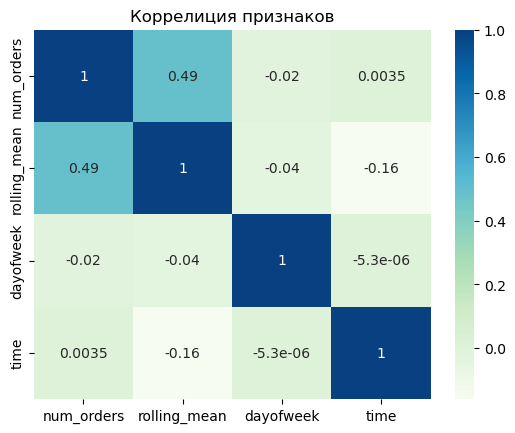

In [25]:
sns.heatmap(df.corr(), annot=True, cmap='GnBu')
plt.title('Коррелиция признаков', fontsize=12);

In [26]:
vif_data = pd.DataFrame() 
vif_data['features'] = df.columns 
  
vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                          for i in range(len(df.columns))] 
  
print(vif_data)

       features       VIF
0    num_orders  5.909786
1  rolling_mean  6.869417
2     dayofweek  2.715472
3          time  2.812912


In [27]:
%%time
 
pipeline = Pipeline([('scaler', StandardScaler()), ('linear_regression', LinearRegression())])
pipeline.fit(features_train_ohe, target_train)

prediction_LR = pipeline.predict(features_train_ohe)
best_score_rough_LR = mean_squared_error(target_train, prediction_LR) ** 0.5

print("Лучшая оценка кросс-валидации:", best_score_rough_LR)

Лучшая оценка кросс-валидации: 24.236221003042637
CPU times: total: 46.9 ms
Wall time: 15 ms


Обучим данные моделью CatBoost:

In [28]:
parametrs = {'depth': range (1, 10),
             'n_estimators': range(1, 10)
}

model_cat = CatBoostRegressor(random_state=R_STATE, learning_rate=0.5)
split_index = TimeSeriesSplit().split(features_train)
grid_search = GridSearchCV(model_cat, param_grid=parametrs, cv=split_index, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train, verbose=False)

best_parametrs_CB = grid_search.best_params_
best_score_rough_CB = -1 * grid_search.best_score_

print("Лучшее значение параметров:", best_parametrs_CB)
print("Лучшая оценка кросс-валидации:", best_score_rough_CB)

Лучшее значение параметров: {'depth': 8, 'n_estimators': 9}
Лучшая оценка кросс-валидации: 26.92210789513563


Обучим данные моделью LGBMRegressor:

In [29]:
%%time

parametrs = {'max_depth': range (1, 10),
             'n_estimators': range(1, 10)
}
model = LGBMRegressor(learning_rate=0.05, random_state=R_STATE)
split_index = TimeSeriesSplit().split(features_train)
grid_search = GridSearchCV(model, param_grid=parametrs, cv=split_index, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train)

best_parametrs = grid_search.best_params_
best_score_rough_L = -1 * grid_search.best_score_

print("Лучшее значение глубины:", best_parametrs)
print("Лучшая оценка кросс-валидации:", best_score_rough_L)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remov

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training from score 67.639456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
Yo

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3307, number of used features: 3
[LightGBM] [Info] Start training from score 72.469610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3307, number of used features: 3
[LightGBM] [Info] Start training from score 72.469610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Aut

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training from score 67.639456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
Yo

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3307, number of used features: 3
[LightGBM] [Info] Start training from score 72.469610
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training from score 67.639456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3307, number of used features: 3
[LightGBM] [Info] Start training from score 72.469610
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3307, number of used features: 3
[LightGBM] [Info] Start training from score 72.469610
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 663, number of used features: 3
[LightGBM] [Info] Start training from score 57.027149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1324, number of used features: 3
[LightGBM] [Info] Start training from score 59.256042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 1985, number of used features: 3
[LightGBM] [Info] Start training from score 63.288665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 2646, number of used features: 3
[LightGBM] [Info] Start training f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 3968, number of used features: 3
[LightGBM] [Info] Start training from score 78.332157
Лучшее значение глубины: {'max_depth': 9, 'n_estimators': 9}
Лучшая оценка кросс-валидации: 33.44883805723826
CPU times: total: 14.3 s
Wall time: 3.7 s


**Вывод:**
- Дополнили данные столбцам и с признаками: rolling mean, year, month, day, time.
- Разделили данные на обучающую и тестовую выборки в соотношении 90:10. 
- Выделили признаки и целевой признак.
- Обучили данные на 4 моделях с подбором параметров: Дерево решений, Линейная регрессия, CatBoost и LGBMRegressor. 
- Лучшая модель LinearRegressor с RMSE - 24.24.

## Тестирование

Протестируем лучшую модель на тестовой выборке:

In [30]:
features_test_ohe = features_test.copy()
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[columns_cat])                                    
features_test_ohe = features_test_ohe.drop(features_test[columns_cat], axis=1)
features_test_ohe = features_test_ohe.reset_index(drop=True)

features_test_ohe

,rolling_mean,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,time_1,time_2,time_3,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
0,120.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,132.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,132.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,126.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,167.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
437,167.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
438,165.714286,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
439,169.428571,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
predict_T = pipeline.predict(features_test_ohe)

In [32]:
best_score_rough_T = mean_squared_error(target_test, predict_T) ** 0.5

print("Лучшая оценка кросс-валидации:", best_score_rough_T)

Лучшая оценка кросс-валидации: 46.5990542315408


Проверим лучшую модель на адекватность на константной модели:

In [34]:
model = DummyRegressor()
model.fit(features_train, target_train)

predictions_DR = model.predict(features_test)
RMSE_DR = mean_squared_error(target_test, predictions_DR)**0.5

print('RMSE:', RMSE_DR)

RMSE: 84.80263773864422


**Вывод:**
- Модель LinearRegressor проверена на тестовой выборке, результат RMSE чуть хуже, чем на тренировочной - 46.6.
- Проверили модель на адекватность на константной модели. Результат 84.8 более, чем в 2 раза хуже результата лучшей модели, т.о., модель  адекватна. 

## Общий вывод

Цель исследования - построить модель, прогнозирующую количество заказов такси на следующий час.

В результате исследования были выполнены следующие шаги:

1) Загружены и рассмотренв представленные данные:
- Данные состоят из 2 столбцов и 26496 строк. 
- Перевели столбец datetime в формат datetime64.
- Ресемплировали данные по одному часу.
- Установили столбец datetime в качестве индекса.

2) Проведен анализ данных и сделаны следующие выводы:
- Представленно измение данных в периоде с марта по сентябрь 2018 года.
- Наблюдается явный тренд к постепенному увеличению количества заказов такси.
- Данные сезонности стационарны (среднее значение и отклонение не изменяются), сезонных изменений по всему периоду и по дням недели не наблюдается.
- В рамках суток видим сезонность по часам. Спрос на такси растет в вечернее время и начинает резко падать после часа ночи. Наименее популярны услуги такси ранним утром около 6 утра.

3) Обучены модели:
- Дополнили данные столбцам и с признаками: rolling mean, year, month, day, time.
- Разделили данные на обучающую и тестовую выборки в соотношении 90:10. 
- Выделили признаки и целевой признак.
- Обучили данные на 4 моделях с подбором параметров: Дерево решений, Линейная регрессия, CatBoost и LGBMRegressor. 
- Лучшая модель LinearRegressor с RMSE - 24.24.

4) Проведено тестирование лучшей модели:
- Модель LinearRegressor проверена на тестовой выборке, результат RMSE чуть хуже, чем на тренировочной - 46.6.
- Проверили модель на адекватность на константной модели. Результат 84.8 более, чем в 2 раза хуже результата лучшей модели, т.о., модель  адекватна.  

Итого, модель успешно построена.
